#**Clustering:**


Is unsupervised technique (i.e. the intent of our model is not to predict the output or label and thus the training data may(not) contain target label as with classification but the label information is not used in training the model.) It aims to "cluster" similar data points into a "cluster" and distinguish between different datapoints by placing them in distict cluster.

What do we mean by similar datapoints? Imagine you are running an ad campgain for a fitness product targeting obese people. Then you gather data of height and weight of people. How can you categorize these people?

You may have a short and obese group, obese but normal height group, normal weight/ height group, slim and tall group and so on. Now you can find patterns among groups instead of blindly running ad campgains. For instance, you may find that most of people in short and obese group prefer X item but not Y item. This act of categorizing or grouping data points (e.g. (height, weight)) into distinct categories or clusters is what clustering is all about. Now, if in future you have a new data point, you can use this pre-made groups to identify what kind of group it falls under and perform corresponding analysis.

## K-means clustering

So, there is a concept of similarity or dissimilarity while making these clusters. We may use different metrics for this. For instance if you were grouping based on heights only, a metric might be absolute height difference between two individuals. So, two individuals might be considered similar if their height differences is small. But, this similarity/dissimilarity was just between two individuals/ datapoints, so, how to extend this concept to a group of people and say a group of people is dintinctly different from the other i.e. a person falls under short-height, medium-height or tall-height group?

*Well one approach is that we take the* **average as representative value of the group** *and say that a person falls in the group to which it is* **closest** *to.*

Note two concepts in above approach:

- Average as the representative value of the group
- Closest (Lowest distance)

K-means does exactly this; it first assumes a representative value for each group and then assigns each points to the group which it is closest to (which is evaluated based on a distance metric for which we often use Euclidean distance). Then it checks if the representative value (centroid (which is fancy way of saying take mean along each feature dimension as the value for the centroids' corresponding dimension)) of each group has changed; if it has then some data points may become more similar to other groups. So, we repeat the process again of assigning group to each point based on closeness to the mean of group and re-evaluating the mean of the group after this assignment. We continue this until the groups remain stable i.e. further aggignment and mean calculation will not bring any change to the groupings.

This wole process can be summarized as:

1) Specify the number of clusters 'K'

2) Initialize cluster centroids

3) Compute diatnace between each data point and the centroids

4) Based on these distances assign each point to the cluster which it is closest to

5) Compute new centrois for each cluster based on above assignment

6) Repeat steps 3, 4 and 5 until convergence

*How to initialize centroids? There are many but we will look at the most simplest one Frogy initialization: Just select K random points from the given data as centroids. Explore other methods like Kmeans++ (but possibly better) which use more complex procedures for initilaization.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Some Helper functions

In [2]:
#first some helper functions we will be reusing later

In [3]:
#a function to convert integer label into color for matplotlib plots used later
#explore the concept of lambda function on your own
label_to_color = lambda x: cm.rainbow(x/3)

In [4]:
def plot_centroids(ax, centroids):
  #scatter function requires x and Y coordinate values in two seperate lists but our centroids variable is expected to contain array of points
  #so we use unpacking operator * along with zip function to get such list
  ax.scatter(*zip(*centroids), marker='X', s = 200, color = 'k', edgecolor = 'w')

In [5]:
def plot_data_points(ax, points, labels=None):
  #based on labels arguments passed, color the data in different ways and plot in  a scatter plot
  color = 'b' #default point color is blue
  if isinstance(labels, str):
    color = labels
  elif isinstance(labels, int):
    color = label_to_color(points[:,labels])
  elif isinstance(labels, np.ndarray):
    color = label_to_color(labels)

  ax.scatter(x = points[:,0], y = points[:,1], c=color)

In [6]:
#see appendix section at last for more info on contourf function and try on your own

def contour_plot(z_value_func, xlim, ylim, resolution = 0.01, figsize = (8,6)):
  xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], resolution), np.arange(ylim[0], ylim[1], resolution))
  mesh_points = np.c_[xx.ravel(), yy.ravel()]  ##numpy.c_ converts 1d array to 2d before concatenating along second axis
  zz = z_value_func(mesh_points)
  zz = zz.reshape(xx.shape)

  plt.figure(figsize=figsize)
  ax = plt.gca()
  ax.contourf(xx, yy, zz, alpha=0.3, cmap='viridis')

  return ax


In [7]:
def distance_func(point1, point2=None, axis = None):
  if point2:
    dist = point1 - point2
  else:
    dist = point1
  return np.linalg.norm(dist, ord=2, axis=axis)

## Generating a synthetic dataset

In [8]:
#some parameters for our datapoint generation:

#center points that we will spread each clusters around
actual_centroids = [(-2.5,5), (5, 12), (10, 0)]

#standard deviation of data points to be generated around above centers
data_points_deviations_from_centroids = (2.5, 2, 3)

#number of clusters
K = len(actual_centroids)

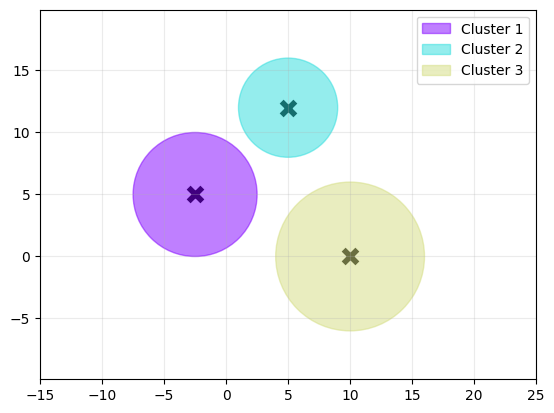

In [9]:
#lets view these cluster points and 2standard-deviation region (95% region) around it to get a feel for the probable cluster region
#as we will be using normal distribution to generate the data points around each cluster centroid
#and adjust our parameters above accordingly to get visualy distinct clusters

#plotting the centroids
plot_centroids(plt, actual_centroids)

plt.axis("equal")
plt.axis([-15, 25, -10, 20])
plt.grid(True, alpha = 0.25)

#plotting the probable region for each cluster
for centroid, deviation, i in zip(actual_centroids, data_points_deviations_from_centroids, range(K)):
  circle = plt.Circle(centroid, radius = 2 * deviation, color=label_to_color(i), alpha=0.5, label=f'Cluster {i+1}')
  plt.gca().add_artist(circle)

plt.legend(loc="upper right")
plt.show()

In [10]:
#generate the datapoints
np.random.seed(10)
cluster_size = (100, 100, 100)

data_points = []

for i in range(K):
  #generate a cluster of random data that is normally distributed around each of the centre points
  data_points_cluster_i = np.random.normal(actual_centroids[i], data_points_deviations_from_centroids[i], size=(cluster_size[i], 2))
  data_points.append(data_points_cluster_i)

#add all datas for every cluster
data_points = np.vstack(data_points)

#lets view some sample data to make sure our shape is correct
data_points[0:5]

array([[ 0.82896626,  6.78819744],
       [-6.36350073,  4.97904038],
       [-0.94666007,  3.1997861 ],
       [-1.83622104,  5.27137131],
       [-2.48927142,  4.56349947]])

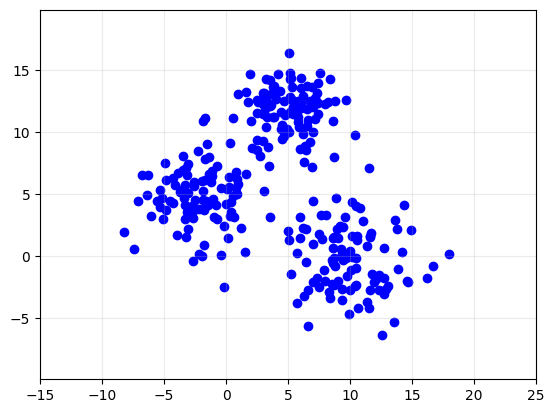

In [11]:
#plotting the generated data points
plot_data_points(plt, data_points)

plt.axis("equal")
plt.axis([-15, 25, -10, 20])
plt.grid(True, alpha = 0.25)

In [12]:
#we can visually see that our data consists of three clusters
#but which cluster does each data point belong to?
#that what clustering is all about and we will implement K-means for our purpose

#Note: this was 2D data so we were able to visually see the clusters but what about 3D, 4D or nD?

## Apply Kmeans algorithm

In [13]:
def kmeans_label_points(centroids, data_points):
  #returns the label for each data point based on closeness to the centroid
  distances_datapoints_centroids = []

  #find distance from each point to each centroid
  for centroid in centroids:
    centroid = centroid.reshape(-1, 2)
    diff_datapoint_centroid_i = data_points - centroid
    distances_datapoints_centroid_i = distance_func(diff_datapoint_centroid_i, axis=1)
    distances_datapoints_centroid_i = distances_datapoints_centroid_i.reshape(-1, 1)
    distances_datapoints_centroids.append(distances_datapoints_centroid_i)

  distances_datapoints_centroids = np.hstack(distances_datapoints_centroids)

  #assign label as the cluster that has the closest centroid to each point
  labels = np.argmin(distances_datapoints_centroids, axis=1)

  return labels

In [65]:
def kmeans_iter(current_centroids, data_points, datapoint_contains_label=False):
  #this performs one iteration of k-means
  K = len(current_centroids)

  #find distance from each point to each centroid
  new_labels = kmeans_label_points(current_centroids, data_points)

  #calculate new centroids
  new_centroids = np.zeros(shape=current_centroids.shape)
  for i in range(K):
    cluster_i_points = data_points[new_labels==i]
    if len(cluster_i_points) == 0:
      #some edge cases might result in empty clusters
      #if thats the case pick a random data point as the centroid
      new_centroids_index = np.random.choice(len(data_points))
      new_centroids[i] = data_points[new_centroids_index]
    else:
      new_centroids[i] = np.mean(cluster_i_points, axis=0)

  return new_labels, new_centroids



In [15]:
#note the function signature below uses keyword-only arguments; explore on your own
def kmeans(K, data_points, max_iter=100, *, datapoints_contain_labels=False, plot_every_n_iterations=1):
  if datapoints_contain_labels:
    data_points_without_labels = data_points[:, :-1]
  else:
    data_points_without_labels = data_points

  #finding the limit of data values just for plotting
  data_xlim = data_points[:, 0].min(), data_points[:, 0].max()
  data_ylim = data_points[:, 1].min(), data_points[:, 1].max()

  #initialization:
  current_iter = 0
  converged = False

  #intialize centroids using frogy initialization
  #i.e. randomly select K points from the data as the initial centroids for K clusters
  current_iter_centroids_indx = np.random.choice(len(data_points_without_labels), size=K, replace=False)
  current_iter_centroids = data_points_without_labels[current_iter_centroids_indx]

  while not converged and current_iter < max_iter:
    current_iter += 1
    new_labels, new_centroids = kmeans_iter(current_iter_centroids, data_points_without_labels)

    if plot_every_n_iterations == 0: ##we used 0 to indicate not to plot
      pass
    elif (current_iter-1) % plot_every_n_iterations == 0:
      #plot how clustering is happening after every n iterations
      labeler_func = lambda points: kmeans_label_points(current_iter_centroids, points)
      ax = contour_plot(labeler_func, data_xlim + (-1, 1), data_ylim + (-1, 1))
      ax.set_title(f'Iteration {current_iter}')

      plot_data_points(ax=ax, points=data_points_without_labels, labels = new_labels)
      plot_centroids(ax, new_centroids)

    if np.allclose(current_iter_centroids, new_centroids):
      converged = True
    else:
      current_iter_centroids = new_centroids

  return new_labels, current_iter_centroids

array([0, 0, 0, 0, 0])

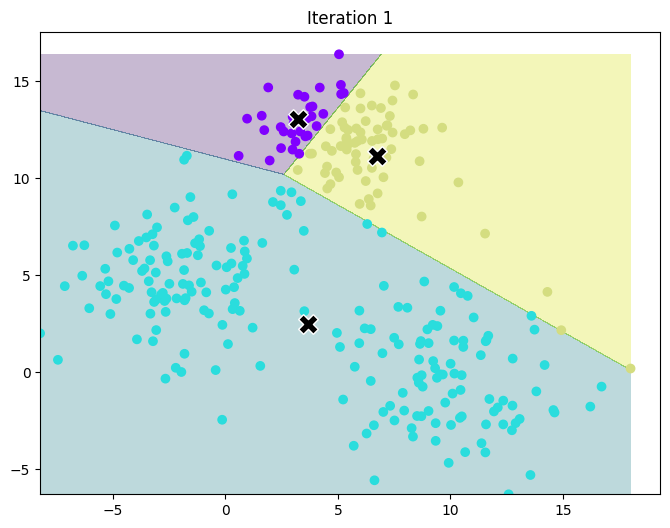

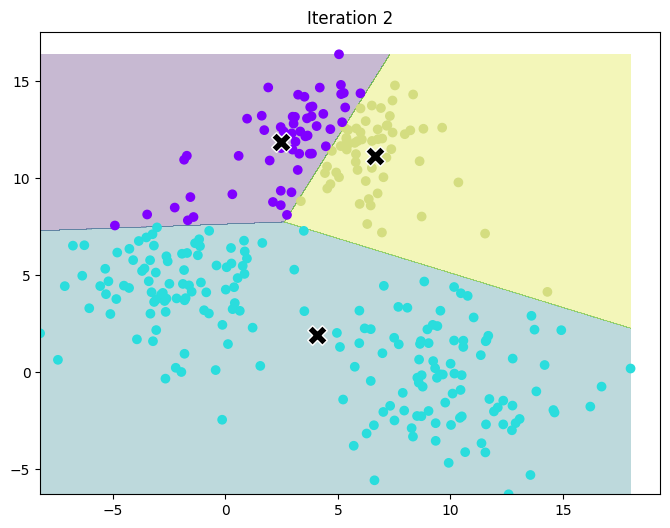

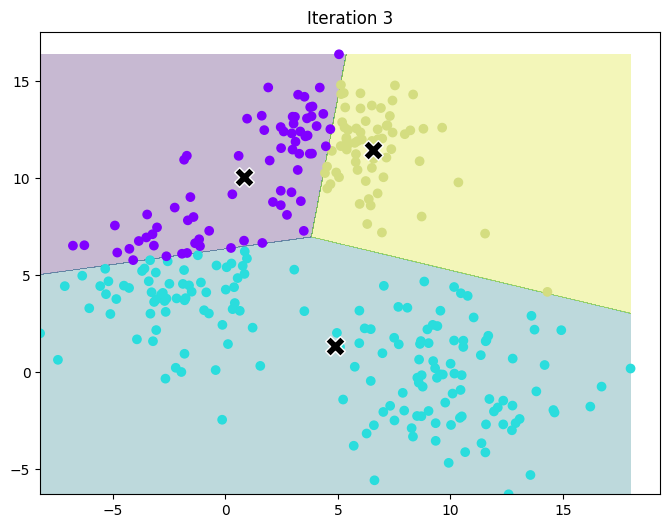

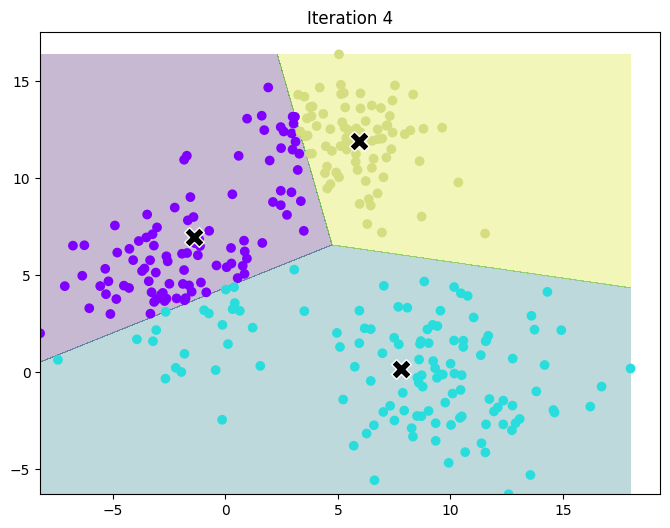

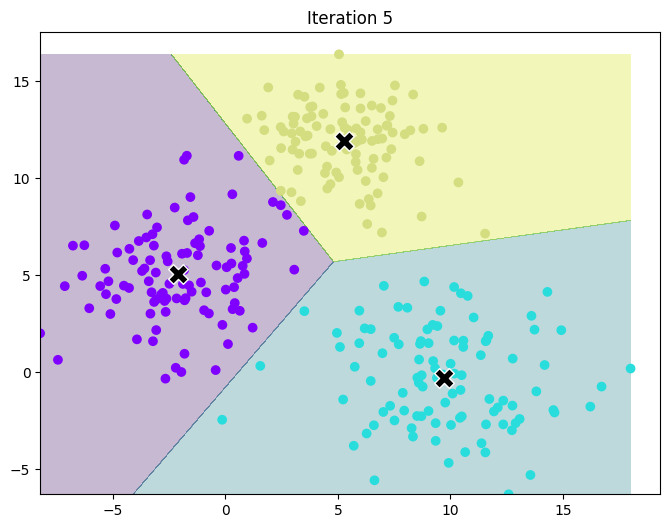

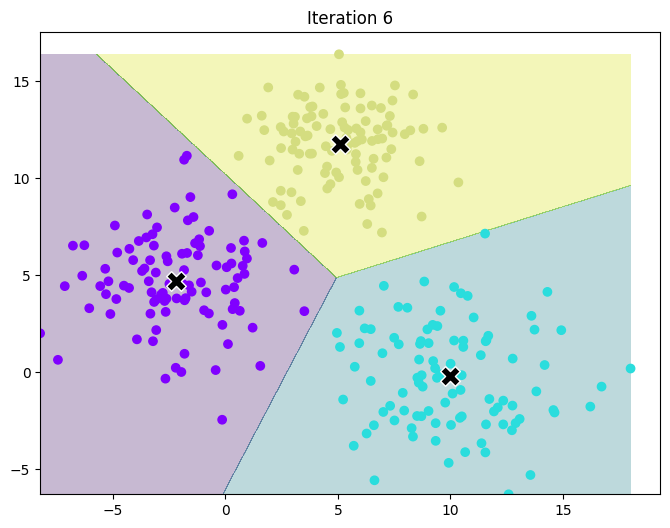

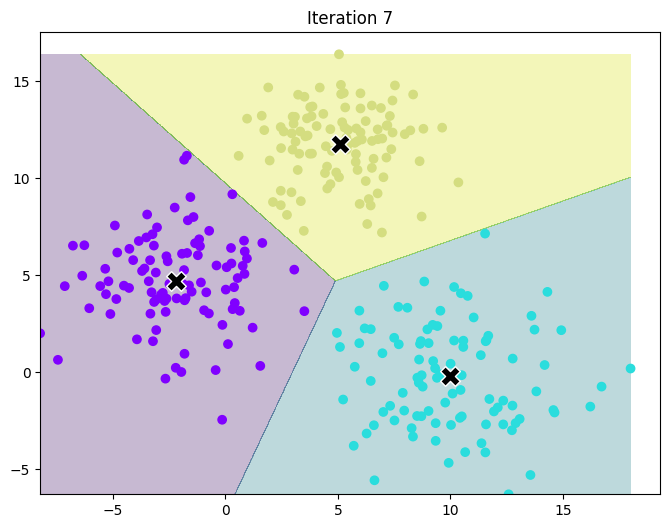

In [16]:
np.random.seed(17)

kmeans_labels, kmeans_centroids = kmeans(3, data_points, plot_every_n_iterations=1)

kmeans_labels[0:5]

## Evaluating clustering

We have seen how to cluster the data points but how do we eavluate the thus formed clustering?

### SSW

Sum of Squares Withnin cluster (SSW): Is the sum of squared difference of each data point from its cluster centroid. That is, it measures how far are the points of cluster from their centers. We prefer low value; meaning each point is as close as possible to the cluster centroid giving compact clusters.

In [17]:
def get_ssw(K, data_points, labels, centroids = None):
    if centroids is None:
        centroids = [ data_points[labels[:] == i ].sum() for i in range(K)]

    ssw = 0
    for i in range(K):
        points_is_in_cluster_i = labels == i
        cluster_i_points = data_points[points_is_in_cluster_i]
        cluster_i_ssw = ((cluster_i_points - centroids[i])**2).sum()

        ssw += cluster_i_ssw

    return ssw / len(data_points)

### SSB

Sum of Squares Between cluster (SSB): Is the sum of squared difference of each cluster centroid from the mean (centroid) of all the datapoints. That is, it measures how far are the centroids from each other. We prefer high value; meaning each centroid is as far as possible from other giving well seperated clusters.

In [18]:
ssw_k3 = get_ssw(3, data_points, kmeans_labels, kmeans_centroids)
ssw_k3

10.608881845865646

In [19]:
#what does this value of SSW tells us?
#This is also a relative measure like MSE so we don't know what is the best value or what kind of values to expect
#The best we can do is compare different clusterings using their SSW values

Text(0.5, 1.0, 'Fig1: Change of SSW with K')

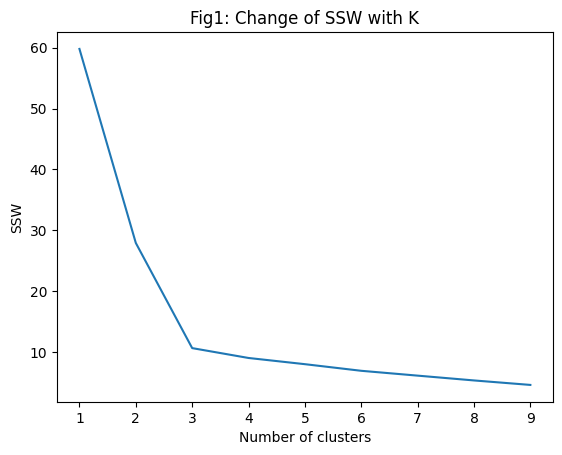

In [63]:
ssw_K = []
Ks = range(1, 10)

np.random.seed(77)

for k in Ks:
  kmeans_labels, kmeans_centroids = kmeans(k, data_points, plot_every_n_iterations=0)
  ssw_K.append(get_ssw(k, data_points, kmeans_labels, kmeans_centroids))

#plot ssw for each number of clusters to choose the best clustring for given dataset
plt.plot(Ks, ssw_K)
plt.xlabel('Number of clusters')
plt.ylabel('SSW')
plt.title('Fig1: Change of SSW with K')


In [21]:
#This seems to suggest 9 is the best value of K
#clearly this is not the case becuase of how we generated data and also seen visually
#so what is wrong?

Text(0.5, 1.0, 'Fig2: Change of SSW with K')

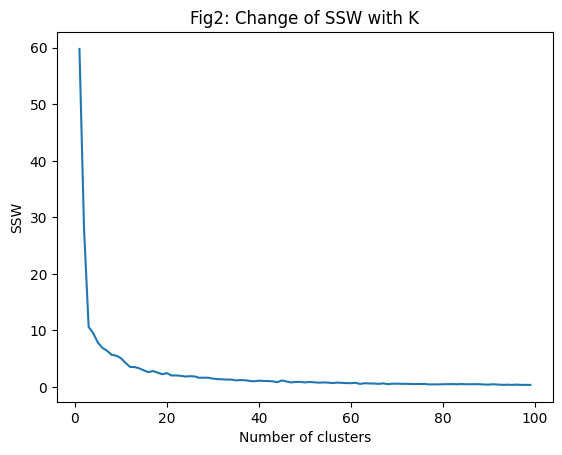

In [66]:
ssw_K = []
Ks = range(1, 100)

np.random.seed(7777)

for k in Ks:
  kmeans_labels, kmeans_centroids = kmeans(k, data_points, plot_every_n_iterations=0)
  ssw_K.append(get_ssw(k, data_points, kmeans_labels, kmeans_centroids))

#plot ssw for each number of clusters to choose the best clustring for given dataset
plt.plot(Ks, ssw_K)
plt.xlabel('Number of clusters')
plt.ylabel('SSW')
plt.title('Fig2: Change of SSW with K')

In [ ]:
#clearly incresing number of cluster seems to decrease SSW
#what is happening?

Observation: Increasing K always decreases SSW as clusters becomes more and more compact; if K = no of data points then each data point is assigned seperate cluster and hence SSW = 0.

## Elbow method

We took number of clusters (or equivalently number of centroids) as 3 for above problem but that is because we had generated our data in such way. But this is not often the case for real-world data where we want to apply K-means clustering algorithm. So, how to get the best value for 'K'?

Elbow method says that the cluster size where there is greatest change in SSW before and after that cluster size (graphically it seems like the point of elbow and hence the name). For instance observe the plot in fig1; 3 is the elbow point. So, it is the best cluster size.

### Silhouette Coefficient (SC)

We have seen one metric that evaluates cluster compactness and the other that measures clusters seperation. Silhouette coefficient combines both into a single formulation:

Measure of compactness *(Measures average distance of $x_i$ to other points in its cluster $C_i$)* :

$a(x_i) = \frac{1}{N_i - 1} \times \sum \limits_{j=1, j\neq i} ^{N_i} d(x_i, x_j)$

where $N_i$ is the number of points in cluster $C_i$ and $d(x_i, d_j)$ is the distance between datapoints $x_i$ and $x_j$

\\

Measure of seperation *(Measures the lowest average distance of $x_i$ to other points in different cluster $C_k$)* :

$b(x_i) = min_{k \in K,k \neq i} [ \frac{1}{N_k} \times \sum \limits_{j=1} ^{N_k} d(x_i, x_j) ]$

where $K$ is the number of clusters, $N_k$ is the number of points in cluster $C_k$ and $d(x_i, d_j)$ is the distance between datapoints $x_i$ and $x_j$

\\

Silhouette coefficient (Combines compactness and seperation measure):
$ SC(x_i) = \frac{ b(x_i) - a(x_i) }{ max\{a(x_i), b(x_i)\} }$

The value of SC lies in between -1 and 1; we prefer closer to 1. Can you think of what negative value would indicate?

*Note that silhouette coefficient is defined for each point. So, to get silhouette coefficient for the whole clustering, we find SC for all data points and then average it.*

In [31]:
#we could write our own implementation for SC but lets use a library
from sklearn.metrics import silhouette_score

In [32]:
kmeans_labels, kmeans_centroids = kmeans(3, data_points, plot_every_n_iterations=0)

sc_k3 = silhouette_score(data_points, kmeans_labels)
print('Silhouette score for cluster size 3: ', sc_k3)

Silhouette score for cluster size 3:  0.3519094907498115


In [ ]:
#what score will we get for different cluster sizes?
#will we have the same problem like with SSW and use elbow method?

Text(0.5, 1.0, 'Fig1: Change of SC with K')

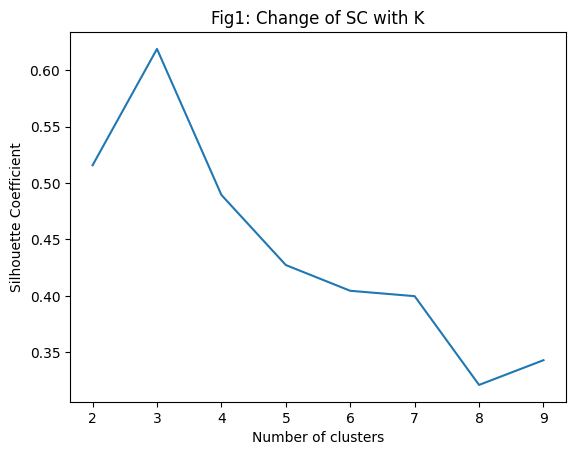

In [34]:
sc_K = []
Ks = range(2, 10)

np.random.seed(77)

for k in Ks:
  kmeans_labels, kmeans_centroids = kmeans(k, data_points, plot_every_n_iterations=0)
  sc_K.append(silhouette_score(data_points, kmeans_labels))

#plot ssw for each number of clusters to choose the best clustring for given dataset
plt.plot(Ks, sc_K)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Fig1: Change of SC with K')

In [ ]:
#we can clealy see we have maximum SC value at K=3
#which is what we expect

**Note:-**
- *Though this algorithm of K-means seems like it goes back and forth and never converge, the Kmeans algorithm is gauranteed to converge as the distances between point and its cluster decreases in every iteration. However, it may converge to local maximum and not the global one depending on what you take as the initial centroid points.*
- *So, we may get some variation based on centroid initialization. Practically we can perform different initializations with different seed values for each cluster size and pick the best one.*

# Appendix

In [ ]:
#contourf plots color for each mesh point based on z value passed
#and then tries to draw contour(curve having same function value; in this case the z-value passed) boundry

In [ ]:
#try out contour plot to see decision boundry

In [ ]:
import numpy

x = [[1, 2, 3, 4], [10, 11, 12, 13]]
y = [2, 4, 6, 8, 9]

xx, yy = numpy.meshgrid(x,y)

In [ ]:
zz = xx + yy

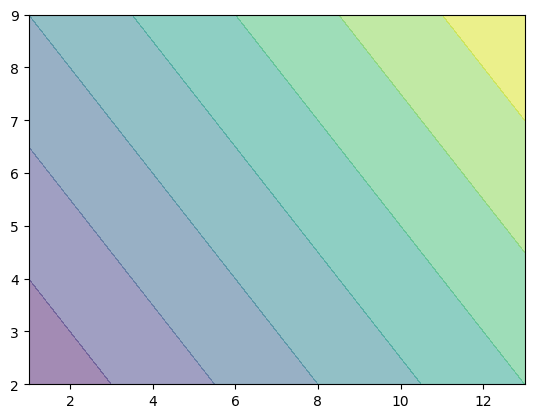

In [ ]:
plt.contourf(xx, yy, zz, alpha = 0.5)